In [ ]:
#!pip install tensorflow==2.3.1
import argparse
import random
import glob
import keras
import keras.applications.inception_v3 as inception_v3
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Add, Concatenate, Input, SeparableConv2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D, LSTM, Reshape, GlobalAveragePooling2D
from keras.layers import BatchNormalization, Flatten
from tensorflow.keras.regularizers import L2

from keras import optimizers
import tensorflow as tf
import gc
import keras

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd

import os
from tqdm import tqdm
pd.options.display.max_colwidth = 1000
tqdm.pandas()

import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import clear_output


In [ ]:
!pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25836 sha256=85ac6449822bf14d732d96f843beeffc726037bf0ce367fa3b6c4f3ac31503bf
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
import imutils
import glob
import os
from PIL import Image
from imutils import paths
import numpy as np
import os
import matplotlib.pyplot as plt

# Directory containing KDEF data
train_dir = '/content/drive/MyDrive/KDEF/KDEF/Train'
test_dir = '/content/drive/MyDrive/KDEF/KDEF/Test'
val_dir = '/content/drive/MyDrive/KDEF/KDEF/Validation'

# Get all image paths
list_train_img = imutils.paths.list_images(train_dir)
list_val_img = imutils.paths.list_images(val_dir)
list_test_img = imutils.paths.list_images(test_dir)
'''
# Print total number of images
print('Total number of KDEF Images:', len(list_train_img))
print('Total number of KDEF Images:', len(list_val_img))
print('Total number of KDEF Images:', len(list_test_img))

# Print the first 5 image paths
print(list_train_img[:5])
'''

Mounted at /content/drive


"\n# Print total number of images\nprint('Total number of KDEF Images:', len(list_train_img))\nprint('Total number of KDEF Images:', len(list_val_img))\nprint('Total number of KDEF Images:', len(list_test_img))\n\n# Print the first 5 image paths\nprint(list_train_img[:5])\n"

In [ ]:
from PIL import Image
from imutils import paths
import numpy as np
import os
import matplotlib.pyplot as plt


In [ ]:
import pandas as pd

# Annotation mapping based on file names
emotion_map_KDEF = {
    'AF': 'afraid',
    'AN': 'angry',
    'DI': 'disgusted',
    'HA': 'happy',
    'NE': 'neutral',
    'SA': 'sad',
    'SU': 'surprised'
}

IMG_WIDTH = 299
IMG_HEIGH = 299
CHANNEL_SIZE = 3

# Function to create dataframe with labels
def create_dataframe(image_list):
    annotations = []
    for img_path in image_list:
        filename = os.path.basename(img_path)
        emotion_code = filename[4:6]  # Extract emotion code from filename
        emotion = emotion_map_KDEF.get(emotion_code)
        if emotion:
            annotations.append((img_path, emotion))
    return pd.DataFrame(annotations, columns=['ImgPath', 'Emotion'])


In [ ]:
# Create dataframes
train_df = create_dataframe(list_train_img)
val_df = create_dataframe(list_val_img)
test_df = create_dataframe(list_test_img)

print('Training set size:', len(train_df))
print('Validation set size:', len(val_df))
print('Test set size:', len(test_df))


Training set size: 3883
Validation set size: 280
Test set size: 560


In [ ]:
def create_image_arrays(dataframe, target_size=(IMG_HEIGH, IMG_WIDTH)):
    images = []
    labels = []
    for index, row in dataframe.iterrows():
        img_path = row['ImgPath']
        label = row['Emotion']
        img = Image.open(img_path)
        img = img.resize(target_size)
        img_array = np.array(img) / 255.0  # Normalize pixel values
        images.append(img_array)
        labels.append(label)
    return np.array(images), np.array(labels)


In [ ]:
train_images, train_labels = create_image_arrays(train_df)
val_images, val_labels = create_image_arrays(val_df)
test_images, test_labels = create_image_arrays(test_df)
print("Train Images Shape:", train_images.shape)
print("Train Labels Shape:", train_labels.shape)
print("Validation Images Shape:", val_images.shape)
print("Validation Labels Shape:", val_labels.shape)
print("Test Images Shape:", test_images.shape)
print("Test Labels Shape:", test_labels.shape)
print(train_df.head())

Train Images Shape: (3883, 299, 299, 3)
Train Labels Shape: (3883,)
Validation Images Shape: (280, 299, 299, 3)
Validation Labels Shape: (280,)
Test Images Shape: (560, 299, 299, 3)
Test Labels Shape: (560,)
                                                    ImgPath Emotion
0  /content/drive/MyDrive/KDEF/KDEF/Train/BM20/BM20AFFL.JPG  afraid
1   /content/drive/MyDrive/KDEF/KDEF/Train/BM20/BM20ANS.JPG   angry
2  /content/drive/MyDrive/KDEF/KDEF/Train/BM20/BM20AFHR.JPG  afraid
3  /content/drive/MyDrive/KDEF/KDEF/Train/BM20/BM20AFFR.JPG  afraid
4  /content/drive/MyDrive/KDEF/KDEF/Train/BM20/BM20AFHL.JPG  afraid


In [ ]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# Create ImageDataGenerators (without rescale, as normalization is already done)
train_datagen = ImageDataGenerator(
    # Add any data augmentations here if needed
)
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

from tensorflow.keras.utils import to_categorical

# One-hot encode labels (Before creating generators)
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_labels)
train_labels_onehot = to_categorical(train_labels_encoded)

val_labels_encoded = label_encoder.transform(val_labels)
val_labels_onehot = to_categorical(val_labels_encoded)

test_labels_encoded = label_encoder.transform(test_labels)
test_labels_onehot = to_categorical(test_labels_encoded)

# Print the mapping from original labels to numeric labels
print("Mapping from original labels to numeric labels:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")

# To demonstrate how to interpret one-hot encoded vectors, let's take an example
example_index = 0  # Change this index to see different examples
print("\nExample of one-hot encoding:")
print(f"Original label: {train_labels[example_index]}")
print(f"Numeric label: {train_labels_encoded[example_index]}")
print(f"One-hot encoded vector: {train_labels_onehot[example_index]}")


Mapping from original labels to numeric labels:
afraid: 0
angry: 1
disgusted: 2
happy: 3
neutral: 4
sad: 5
surprised: 6

Example of one-hot encoding:
Original label: afraid
Numeric label: 0
One-hot encoded vector: [1. 0. 0. 0. 0. 0. 0.]


In [ ]:

# Create data generators from NumPy arrays (using one-hot encoded labels)
train_generator = train_datagen.flow(
    x=train_images,
    y=train_labels_onehot,  # Use one-hot encoded labels
    batch_size=32,
    #target_size=(224, 224),  # Set target size for InceptionV3
    #class_mode='categorical'
)

val_generator = val_datagen.flow(
    x=val_images,
    y=val_labels_onehot,  # Use one-hot encoded labels
    batch_size=32,
    #target_size=(224, 224),  # Set target size for InceptionV3
    #class_mode='categorical'
)

test_generator = test_datagen.flow(
    x=test_images,
    y=test_labels_onehot,  # Use one-hot encoded labels
    batch_size=32,
    #target_size=(224, 224),  # Set target size for InceptionV3
    #class_mode='categorical',
    shuffle=False  # Important for evaluation
)

In [ ]:
'''from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image data generator
generator = ImageDataGenerator(rescale=1./255)

training_set_KDEF = generator.flow_from_dataframe(
    dataframe=train_kdef_df,
    x_col='ImgPath',
    y_col='Emotion',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='categorical',
    batch_size=32
)

validation_set_KDEF = generator.flow_from_dataframe(
    dataframe=test_kdef_df,
    x_col='ImgPath',
    y_col='Emotion',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='categorical',
    batch_size=32
)
'''

Found 3428 validated image filenames belonging to 7 classes.
Found 1470 validated image filenames belonging to 7 classes.


In [ ]:

class TrainingPlot(keras.callbacks.Callback):

  # This function is called when the training begins
  def on_train_begin(self, logs={}):
    # Initialize the lists for holding the logs, losses and and accuracies
    self.losses = []
    self.acc = []
    self.logs = []
    self.val_losses = []
    self.val_acc = []

  # This function is called at the end of each epoch
  def on_epoch_end(self, epoch, logs={}):
    # Append the logs, losses, and accuracies to the lists
    self.logs.append(logs)
    self.losses.append(logs.get('loss'))
    self.acc.append(logs.get('accuracy'))
    self.val_losses.append(logs.get('val_loss'))
    self.val_acc.append(logs.get('val_accuracy'))

    # Before plotting ensure at least 2 epochs have passed
    if len(self.losses) > 1:

      # Clear the previous plot
      clear_output(wait=True)
      N = np.arange(0, len(self.losses))

      # You can chose the style of your preference
      # print(plt.style.available) to see the available options
      plt.style.use("seaborn")

      # Plot train loss, train acc, val loss and val acc against epochs passed
      plt.figure()
      plt.plot(N, self.losses, label = "Training Loss")
      plt.plot(N, self.val_losses, label = "Val loss")
      plt.title("Training Loss and Accuracy")
      plt.xlabel("Epoch #")
      plt.ylabel("Loss")
      plt.legend()
      plt.show()

      plt.plot(N, self.acc, label = "Training Acc")
      plt.plot(N, self.val_acc, label = "Val Acc")
      plt.title("Training Loss and Accuracy ")
      plt.xlabel("Epoch #")
      plt.ylabel("Accuracy")
      plt.legend()
      plt.show()
plot_losses = TrainingPlot()

In [ ]:
import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  
REPLICAS:  8


In [ ]:

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Bidirectional, LSTM, Reshape,TimeDistributed, Flatten
from tensorflow.keras.models import Model
'''
# Define the new inceptionv3_bilstm function with 7 classes
def inceptionv3_bilstm(input_shape=(224, 224, 3), num_classes=7):
    base_model = InceptionV3(include_top=False, weights="imagenet", input_shape=input_shape)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    reshaped_dim = x.shape[1] // 4  # Adjust reshaping
    x = Reshape((4, reshaped_dim))(x)

    x = Bidirectional(LSTM(128, return_sequences=True))(x)

    x = Dense(1024, activation="relu")(x)
    out = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=out)
    return model
'''
with strategy.scope():
    def inceptionv3_bilstm(input_shape=(299, 299, 3), num_classes=7):
        base_model = InceptionV3(include_top=False, weights="imagenet", input_shape=input_shape, )

        x = base_model.output
        x = GlobalAveragePooling2D()(x)

        reshaped_dim = x.shape[1] // 8
        x = Reshape((8, reshaped_dim))(x)

        x = Bidirectional(LSTM(128, return_sequences=True))(x)
        x = TimeDistributed(Flatten())(x)
        x= Flatten()(x)

        x = Dense(1024,  activation='relu')(x)
        x = Dropout(0.51)(x)
        x=  Dense(512, activation='relu')(x)
        x = Flatten()(x)
        out = Dense(num_classes, activation="softmax")(x)

        model = Model(inputs=base_model.input, outputs=out)
        return model

# Instantiate the model
model = inceptionv3_bilstm(input_shape=(IMG_HEIGH, IMG_WIDTH, CHANNEL_SIZE), num_classes=7)

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

# Model summary
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_188 (Conv2D)         (None, 149, 149, 32)         864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_188 (B  (None, 149, 149, 32)         96        ['conv2d_188[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_188 (Activation  (None, 149, 149, 32)         0         ['batch_normalization_18

In [ ]:

!pip install keras-swa
from swa.tfkeras import SWA
start_epoch = 4

## define swa callback
swa = SWA(start_epoch=start_epoch,
           lr_schedule='cyclic',
           swa_lr=0.00001,
           swa_lr2=0.00005,
           swa_freq=3,
           batch_size=32, # needed when using batch norm
          verbose= 1)


<ipython-input-27-0b6c8944beac>:30: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


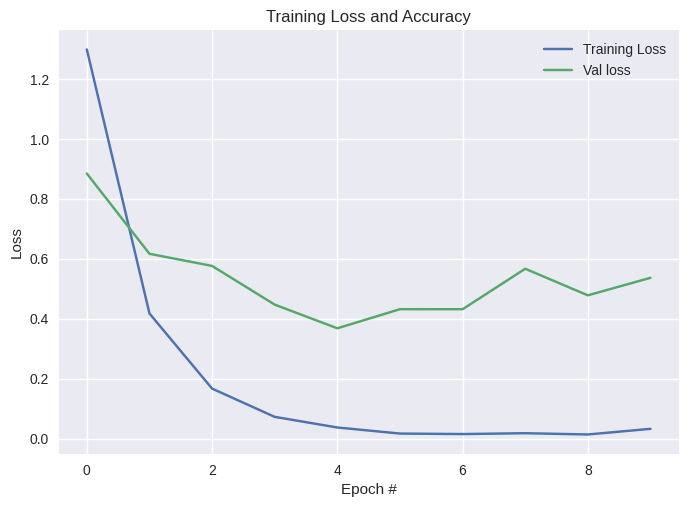

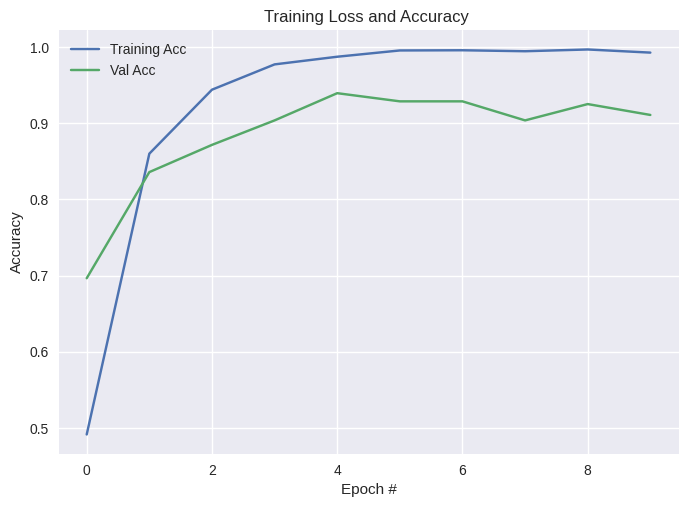

122/122 [==============================] - 283s 2s/step - loss: 0.0329 - accuracy: 0.9925 - val_loss: 0.5366 - val_accuracy: 0.9107


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


NameError: name 'final_accuracy' is not defined

In [ ]:
# Train the model
from tensorflow.keras.callbacks import EarlyStopping

other_callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

all_callbacks = other_callbacks + [swa] + [plot_losses]

History = model.fit(
    train_generator,
    batch_size=32,
    validation_data=val_generator,
    epochs=30,
    callbacks=all_callbacks,
    verbose=1,
    shuffle=False
)

model_path = '/content/drive/My Drive/KDEF/IncpKDEF.h5'
model.save(model_path)

# Print final accuracy
#final_accuracy = History.history['val_acc'][-1]
print("Final validation accuracy:", final_accuracy)


In [ ]:
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [ ]:
!pip install tabulate

18/18 [==============================] - 6s 313ms/step - loss: 0.2464 - accuracy: 0.9339
Test accuracy: 0.9339285492897034
18/18 [==============================] - 8s 334ms/step
Accuracy: 0.9339285714285714
Precision (Macro): 0.9347200136652922
Recall (Macro): 0.9339285714285713
F1-Score (Macro): 0.9338950815671242
╒══════════════════╤════════════════════╤════════════════════╤════════════════════╤════════════╕
│                  │ precision          │ recall             │ f1-score           │    support │
╞══════════════════╪════════════════════╪════════════════════╪════════════════════╪════════════╡
│ afraid           │ 0.8734177215189873 │ 0.8625             │ 0.8679245283018868 │  80        │
├──────────────────┼────────────────────┼────────────────────┼────────────────────┼────────────┤
│ angry            │ 0.8941176470588236 │ 0.95               │ 0.9212121212121211 │  80        │
├──────────────────┼────────────────────┼────────────────────┼────────────────────┼────────────┤
│ di

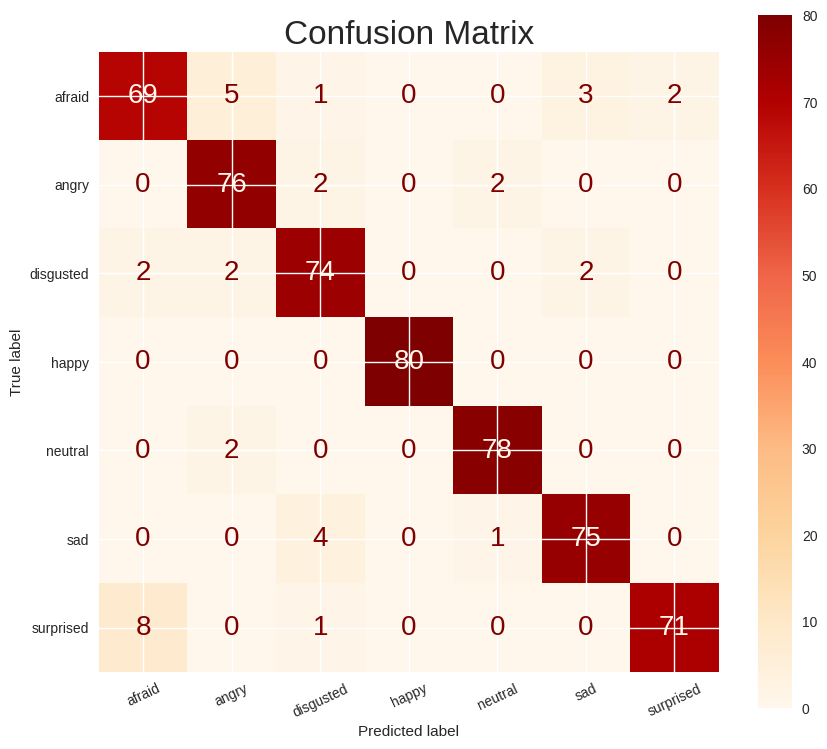

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tabulate import tabulate

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test accuracy:", test_accuracy)

# Generate predictions
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

# Use the original test labels
y_true = test_labels_encoded

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)
final_loss = total_loss / num_batches
print(f"Final Loss: {final_loss:.4f}")  # Print the final loss
# Calculate precision, recall, and F1-score (macro-averaged)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
print("Precision (Macro):", precision)
print("Recall (Macro):", recall)
print("F1-Score (Macro):", f1)

# Generate classification report
report = classification_report(y_true, y_pred, target_names=label_encoder.classes_, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df_filtered = report_df.drop('accuracy')
report_df_filtered.loc['overall_accuracy'] = ['', '', '', accuracy]
print(tabulate(report_df_filtered, headers='keys', tablefmt='fancy_grid'))

# Generate and plot confusion matrix
c_m = confusion_matrix(y_true, y_pred)
display_c_m = ConfusionMatrixDisplay(confusion_matrix=c_m, display_labels=label_encoder.classes_)

plt.rcParams['figure.figsize'] = (10.0, 9.0)
plt.rcParams['font.size'] = 20
display_c_m.plot(cmap='OrRd', xticks_rotation=25)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Confusion Matrix', fontsize=24)
plt.show()
